# Transfer learning
Este Projeto foi realizado por Maurício André de Almeida como trabalho no curso de Treinamento de Redes Neurais com Transfer Learning na DIO.ME


# Projeto de Transfer Learning em Python
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  
Para exemplo, utilizaremos o seguinte projeto que realiza Transfer Learning com o Dataset do MNIST:
 https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb
O dataset utilizado engloba duas classes: gatos e cachorros. Uma descrição da base de dados pode ser visualizada neste link: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs.
Já o dataset para download pode ser acessado por meio deste outro link:
https://www.microsoft.com/en-us/download/details.aspx?id=54765.

Observações: Neste projeto, você pode usar sua própria base de dados (exemplo: fotos suas, dos seus pais, dos seus amigos, dos seus animais domésticos, etc), o exemplo de gatos e cachorros, pode ser substituído por duas outras classes do seu interesse. O Dataset criado em nosso projeto anterior, pode ser utilizado agora.  
O projeto deve ser enviado para o GitHub da DIO: https://github.com/digitalinnovationone.


#Para iniciarmos, vamos carregar todas as bibliotecas necessárias:

In [2]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [3]:
from shutil import copyfile


import tensorflow as tf
#Garbage Collector - use it like gc.collect()
import gc
class GarbageCollectorCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

### Carregando o dataset

Iremos carregar o dataset manualmente no Collab na pasta Content

baixar localmente do site: https://www.microsoft.com/en-us/download/details.aspx?id=54765

descompactar localmente, compactar separadamente o aquivo Cat.zip e Dog.zip com o diretório correspondente.

Realizar o upload dos arquivos zip no Collab, utilizando o ícone da Pasta no lado esquerdo da tela

**Descompactar os arquivos zipados**

In [3]:
!echo "Descompactando cats & dogs"

!unzip -q Cat.zip
!unzip -q Dog.zip
!ls


Descompactando cats & dogs
Cat  Cat.zip  Dog  Dog.zip  sample_data


**Remover os arquivos .zip**


In [4]:
!rm Cat.zip
!rm Dog.zip

In [1]:
3!rm -f -r cats+dogs


**Verificar quantas imagens tem em cada pasta**

In [4]:
print(len(os.listdir('Cat/')))
print(len(os.listdir('Dog/')))

7497
7494


**Limpar o dataset**

In [5]:
# Remover arquivos inválidos
files = ['Cat/', 'Dog/']
for path in files:
     for filename in os.listdir(path):
        file = path + filename
        if os.path.getsize(file) == 0:
            print(file+' é um arquivo vazio, removendo...')
            os.remove(file)



Realizar a verificação de cada imagem e remover os arquivos com erro

In [6]:
# Código retirado do forum, do amigo Luiz Silva
# https://web.dio.me/topics/desafio-treinamento-de-redes-neurais-com-transfer-learning-1?back=%2Ftrack%2Fcoding-the-future-baires-dev-machine-learning-practitioner&page=1&order=oldest

def validate_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False

dataset_path = 'Cat'
valid_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')) and validate_image(file_path):
            valid_files.append(file_path)
        else:
            print(f"Arquivo inválido: {file_path}")
            os.remove(file_path)

dataset_path = 'Dog'

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')) and validate_image(file_path):
            valid_files.append(file_path)
        else:
            print(f"Arquivo inválido: {file_path}")
            os.remove(file_path)

**Função para mover os arquivos para o diretório correto**

In [7]:
def mover_dataset(SOURCE, DEST, LIMITE):
    cont = 0
    files = os.listdir(SOURCE)
    random.shuffle(files)
    for filename in files:
      file = SOURCE + filename
      cont += 1
      if cont <= LIMITE:
        destination = DEST + filename
        copyfile(file, destination)
        os.remove(file)


**Mover 3000 arquivos de cada categoria para formar o dataset, sem estourar a memória do Google Colab.**

As demais serão mantidas na pasta, e poderão ser utilizadas para fazer o teste final do modelo retreinado

In [8]:
# Definido um limite de 500 por categoria devido às restrições de memória do Collab
limite = 3000
os.mkdir('cats+dogs')
dest_cats = 'cats+dogs/Cats/'
dest_dogs = 'cats+dogs/Dogs/'
os.mkdir(dest_cats)
mover_dataset('Cat/',dest_cats, limite)
os.mkdir(dest_dogs)
mover_dataset('Dog/',dest_dogs, limite)



**Verificar quantas imagens ficaram em cada pasta**

In [9]:
print(len(os.listdir('cats+dogs/Cats/')))
print(len(os.listdir('cats+dogs/Dogs/')))

3000
3000


Carregar as categorias

In [10]:
root = 'cats+dogs/'
exclude = [] #[]'BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']


categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]


print(categories)

['cats+dogs/Cats', 'cats+dogs/Dogs']


In [11]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

**Função para percorrer os arquivos e armazena-los no vetor data**

In [12]:
data = []


for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
          img, x = get_image(img_path)
          data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

#Definir a divisão do dataset entre:

*  70% Training set
*  15% Validating set
*  15% Testing set



In [13]:
train_split = 0.7
val_split = 0.15

Aleatorizar o vetor data

In [14]:
random.shuffle(data)

criar os sets de training / validation / test

split (70%, 15%, 15%)

In [15]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

# Remover data para liberar memoria
del data
gc.collect()

0

criar os sets de treino, validação e testes

In [16]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 

limpar memória, removendo variáveis sem uso

In [17]:
# Remover data para liberar memoria
train = []
val = []
test = []
del train
del val
del test

gc.collect()

0

Preparação final dos datasets de treinamento, validação e testes.

Normalizar os dados para float32 entre 0 e 1.


In [18]:
num_classes = 2

# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(900, 2)


# Exibir um Sumario do dataset que será utilizado:

In [19]:
# summary
#print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


train / validation / test split: 4200, 900, 900
training data shape:  (4200, 224, 224, 3)
training labels shape:  (4200, 2)


**Verificar algumas das imagens carregadas**

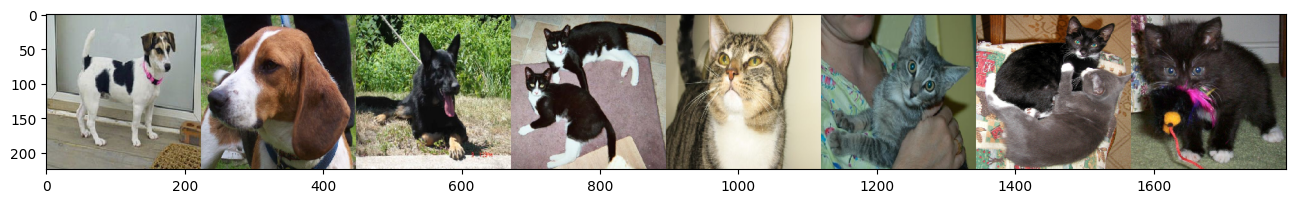

In [20]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Carregar o modelo imagenet pré-treinado

In [21]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

**Recriar o modelo removendo o layer final que contem a classificação (imagenet)**

In [22]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


**Retreinar o modelo com o dataset cats+dogs**



In [23]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

** O sumario mostra um modelo identico ao original, apenas diferenciado pela última camada que contém apenas 2 categorias **



In [24]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5912 - loss: 0.7864 - val_accuracy: 0.8478 - val_loss: 0.4134
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 679ms/step - accuracy: 0.8585 - loss: 0.3880 - val_accuracy: 0.8667 - val_loss: 0.3387
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 718ms/step - accuracy: 0.8830 - loss: 0.3153 - val_accuracy: 0.8767 - val_loss: 0.3077
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 707ms/step - accuracy: 0.8894 - loss: 0.2951 - val_accuracy: 0.8867 - val_loss: 0.2870
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 698ms/step - accuracy: 0.8982 - loss: 0.2690 - val_accuracy: 0.8933 - val_loss: 0.2710
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 681ms/step - accuracy: 0.9001 - loss: 0.2521 - val_accuracy: 0.8867 - val_loss: 0.2698
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 714ms/step - accuracy: 0.9073 - loss: 0.2394 - val_accuracy: 0.8644 - val_loss: 0.2942
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.8954 - loss: 0.2436 - val_accurac

Após 10 épocas treinando o modelo com um dataset reduzido, atingimos uma acurácia de 90% e perda de 0.25

Agora vamos plotar o grafico de loss e accuracy de nosso modelo retreinado


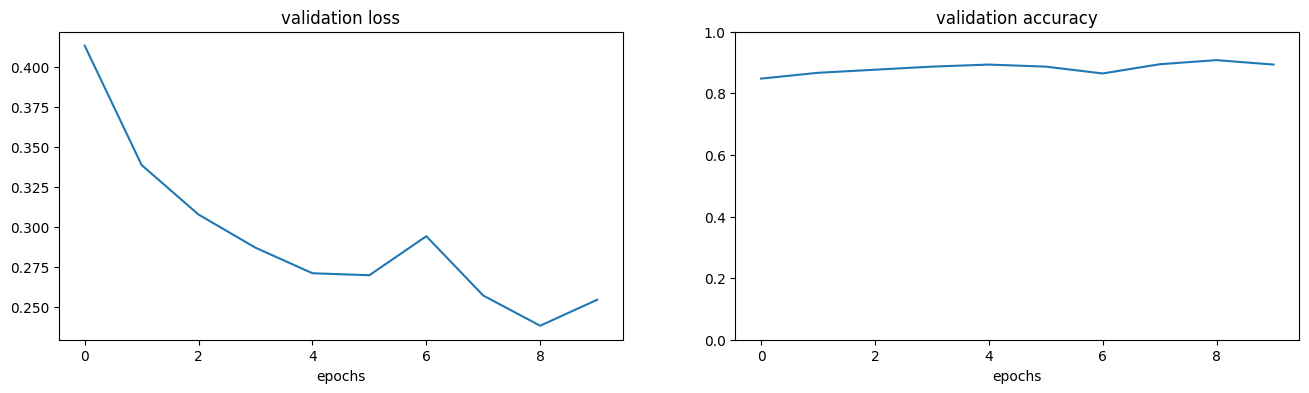

In [25]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
#ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
#ax2.plot(history.history["val_acc"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Validação final do modelo:

In [26]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.23483628034591675
Test accuracy: 0.9011111259460449


Agora vamos testar nosso modelo com algumas imagens que ficaram de fora dos dataset utilizados


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 224, 224, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Arquivo: Cat/10064.jpg - Probab: Categ 0: 100% - Categ 1: 0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Arquivo: Dog/8833.jpg - Probab: Categ 0: 0% - Categ 1: 100%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Arquivo: Cat/9111.jpg - Probab: Categ 0: 100% - Categ 1: 0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Arquivo: Dog/2939.jpg - Probab: Categ 0: 0% - Categ 1: 100%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Arquivo: Dog/9996.jpg - Probab: Categ 0: 0% - Categ 1: 100%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Arquivo: Cat/8053.jpg - Probab: Categ 0: 100% - Categ 1: 0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Arquivo: Cat/883.jpg - Probab: Categ 0: 51% - Categ 1: 48%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Arquivo: Dog/7723.jpg - Probab: Categ 0: 0% - Categ 1: 100%


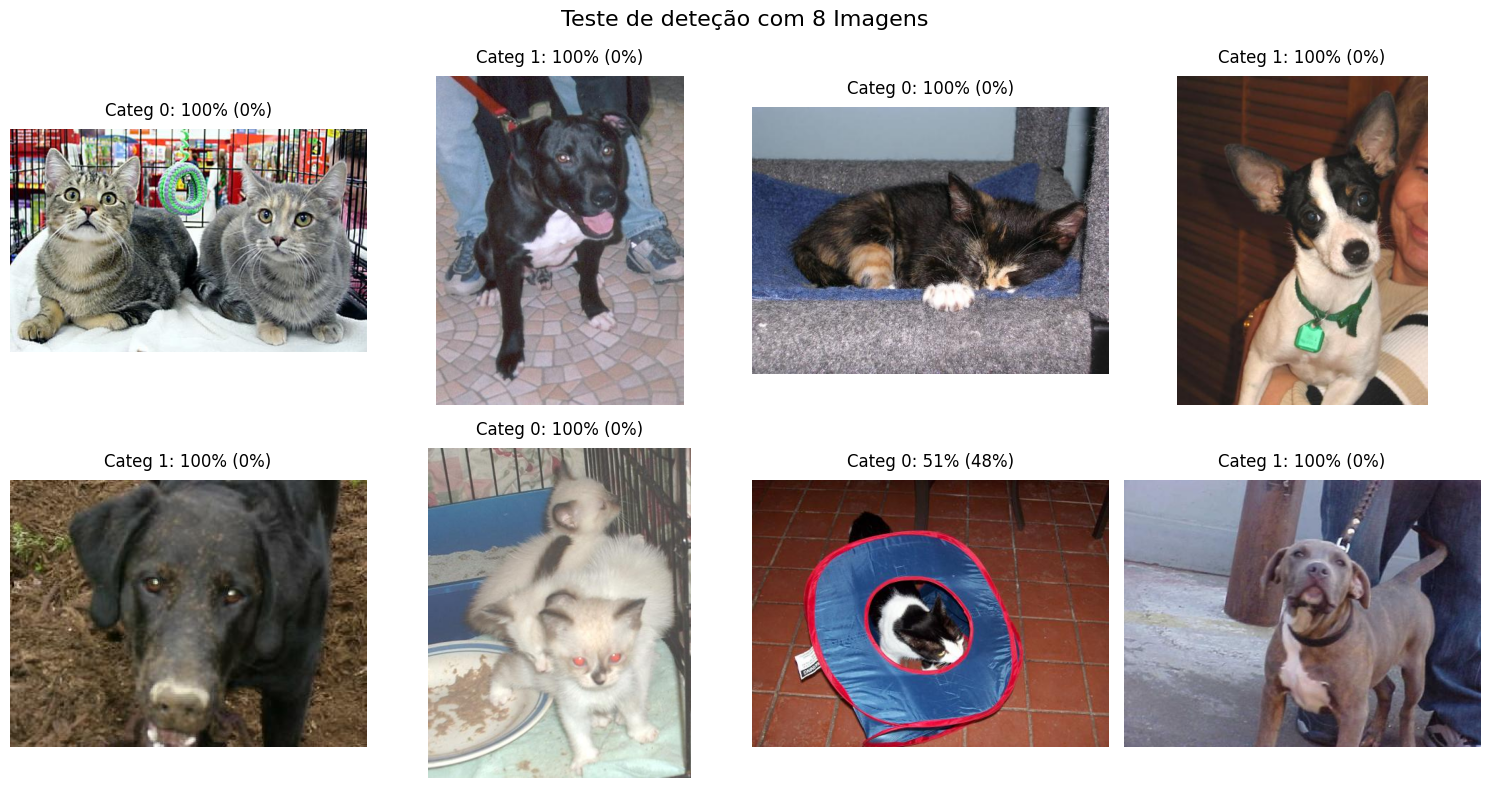

In [27]:
def testar_imagens():
   data = []
   paths = ['Cat/', 'Dog/']
   for caminho in paths:
       data = data+[os.path.join(dp, f) for dp, dn, filenames
              in os.walk(caminho) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
   random.shuffle(data)
   img_res = []
   img_catg = []
   idx = [int(len(data) * random.random()) for i in range(8)]
   test_data = [data[i] for i in idx]
   for i in test_data:
      img, x = get_image(i)
      probabilities = model_new.predict([x])
      prob0 = int(probabilities[0,0]*100)
      prob1 = int(probabilities[0,1]*100)
      if probabilities[0,0] > probabilities[0,1]:
         catg = 'Categ 0: ' + str(prob0) + '% ('+str(prob1)+'%)'
      else:
         catg = 'Categ 1: ' + str(prob1) + '% ('+str(prob0)+'%)'
      print('Arquivo: '+ i + ' - Probab:' + ' Categ 0: '+ str(prob0) + '% - Categ 1: '+ str(prob1) + '%')
      img_res.append(i)
      img_catg.append(catg)

   fig, axes = plt.subplots(2, 4, figsize=(15, 8))
   for i, ax in enumerate(axes.flat):
      if i < len(img_res):
         try:
               img = image.load_img(img_res[i])
               ax.imshow(img)
               ax.set_title(img_catg[i], fontsize=12, pad=10)  # Ajusta o pad para alinhar o título
               ax.axis("off")  # Remove os eixos (opcional)
         except FileNotFoundError:
               ax.set_title(f"Imagem {i+1} não encontrada", fontsize=12, pad=10)
               ax.axis("off")
   plt.tight_layout(rect=[0, 0, 1, 0.95])
   plt.suptitle("Teste de deteção com 8 Imagens", fontsize=16)
   plt.show()

testar_imagens()

Podemos observar que o modelo conseguiu acertar em 100% das imagens de teste, atingindo seu objetivo e classificando corretamente as imagens.